## Oxford-IIIT Pet Dataset 을 이용하여 segmentation 학습하기

이 실습에서는 미리 저장된 tfrecord file을 읽어와서 unet과 비슷한 network을 이용항 segmentation을 학습시켜 봅니다.
이 때, vgg와 유사하게 network을 만들어서 vgg의 pretrained model을 불러와서 학습을 해보도록 하겠습니다.

### 이 실습 file부터 진행하는 경우 준비사항
9_1을 건너뛰고 이번 file부터 실습을 하는 경우 아래 경로에서 tfrecord file을 다운 받은 후,  
train tfrecord file:  https://drive.google.com/file/d/1lejq39iRTpQjKH4iZwoL_hCyxzXgoaox/view?usp=sharing  
validation tfrecord file: https://drive.google.com/file/d/1qiqEJkcdaHWJUSTX43X-PsihM8PZ6_gt/view?usp=sharing 

실습 directory에 dogs_tfr 이라는 이름의 directory를 생성하고 위에서 download 받은 file을 upload 해야 실습이 진행 가능합니다

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from matplotlib.patches import Rectangle

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.2.4-tf


In [9]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [3]:
cd '/content/gdrive/My Drive/TensorFlow_Training_13th'

In [4]:
## hyper parameter 설정
batch_size = 10
learning_rate = 0.0001
training_epochs = 20
img_size = 224
n_train = 2000
n_val = 498

In [5]:
## tfrecord file 경로 설정
cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'dogs_tfr')

tfr_train = 'dogs_seg_train.tfrecord'
tfr_val = 'dogs_seg_val.tfrecord'

tfr_train_dir = os.path.join(tfr_dir, tfr_train)
tfr_val_dir = os.path.join(tfr_dir, tfr_val)

In [6]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'seg': tf.io.FixedLenFeature([], tf.string),
              'grayimg': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_size, img_size, 3])
    image = tf.cast(image, tf.float32)/255.
    #image = preprocess_input(image)
    
    seg = tf.io.decode_raw(parsed_features['seg'], tf.uint8)
    seg = tf.reshape(seg, [img_size, img_size, -1])
    seg = tf.cast(seg, tf.float32)
    
    grayimg = tf.io.decode_raw(parsed_features['grayimg'], tf.float64)    
    grayimg = tf.reshape(grayimg, [img_size, img_size])
    grayimg = tf.stack([grayimg, grayimg, grayimg], -1)
    grayimg = tf.cast(grayimg, tf.float32)/255.
    #print(grayimg.shape)
    
    return image, seg

In [15]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
#train_dataset = train_dataset.prefetch(buffer_size=batch_size).batch(batch_size).repeat()
train_dataset = train_dataset.prefetch(buffer_size=batch_size).batch(batch_size).shuffle(n_train*2).repeat()
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

(224, 224, 3)


In [16]:
## validation datset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=8)
val_dataset = val_dataset.prefetch(buffer_size=batch_size).batch(batch_size)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

(224, 224, 3)


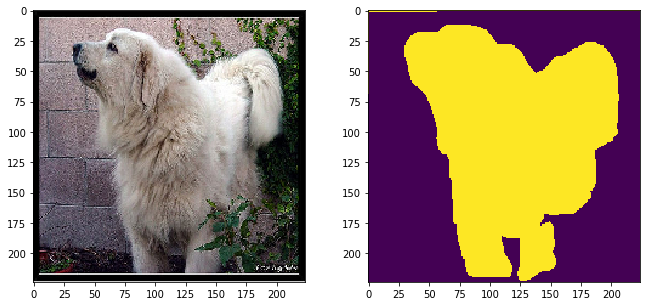

In [17]:
## train dataset에서 1개의 image와 segmentation label을 읽어서 확인
for image, seg in train_dataset.take(1):
    plt.figure(figsize=(11, 5))
    plt.subplot(1,2,1)
    plt.imshow(image[0])
    plt.subplot(1,2,2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1) 
    plt.show()  

In [19]:
from tensorflow.keras.utils import get_file

In [20]:
## vgg16 pretrained weights 다운로드
weight_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [21]:
def create_model():
    inputs = Input(shape=(img_size, img_size, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)
    
    ## loading vgg16 pretrained weights
    vgg = keras.Model(inputs, pool5_4)
    vgg.load_weights(weight_path)
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(2, 1, 1, 'SAME', activation='softmax')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12) 
    

In [22]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [23]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(optimizers.Adam(lr_schedule), loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [24]:
## Train!
steps_per_epoch = n_train//batch_size
validation_steps = n_val//batch_size
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=training_epochs,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/20


W0810 08:57:58.909527 15588 deprecation.py:323] From c:\users\jwlee\anaconda3\envs\tf2_gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


200/200 [==============================] - 76s 381ms/step - loss: 0.3678 - sparse_categorical_accuracy: 0.8315 - val_loss: 0.2139 - val_sparse_categorical_accuracy: 0.9164
Epoch 2/20
200/200 [==============================] - 67s 336ms/step - loss: 0.1833 - sparse_categorical_accuracy: 0.9268 - val_loss: 0.1731 - val_sparse_categorical_accuracy: 0.9343
Epoch 3/20
200/200 [==============================] - 67s 336ms/step - loss: 0.1511 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.1602 - val_sparse_categorical_accuracy: 0.9393
Epoch 4/20
200/200 [==============================] - 67s 337ms/step - loss: 0.1301 - sparse_categorical_accuracy: 0.9491 - val_loss: 0.1417 - val_sparse_categorical_accuracy: 0.9442
Epoch 5/20
200/200 [==============================] - 67s 337ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.1376 - val_sparse_categorical_accuracy: 0.9472
Epoch 6/20
200/200 [==============================] - 67s 335ms/step - loss: 0.0956 - sparse_cat

### pretrained weight load(optinal)
미리 학습된 weight를 가져와서 학습할 경우 아래 comment를 지우고 load_weights를 실행  
미리 학습된 weight 위치: https://drive.google.com/file/d/1oYfFriQKqgH95Yo6bX29xeisZuoOCR_G/view?usp=sharing  
위 link에서 .h5 파일을 download한 후에 실습 directory에 'saved_weights'라는 directory를 만든 후 .h5 파일을 upload

In [ ]:
#weight_path = ('./saved_weights/segmentation_pretrained_vgg.h5')
#model.load_weights(weight_path)

In [25]:
## validation data에 대한 예측값 생성
prediction = model.predict(val_dataset)

In [27]:
pred = np.zeros_like(prediction)

In [28]:
## 0.5이상은 1로 나머지는 0으로 변환
thr = 0.5
pred[prediction>=thr] = 1
pred[prediction<thr] = 0

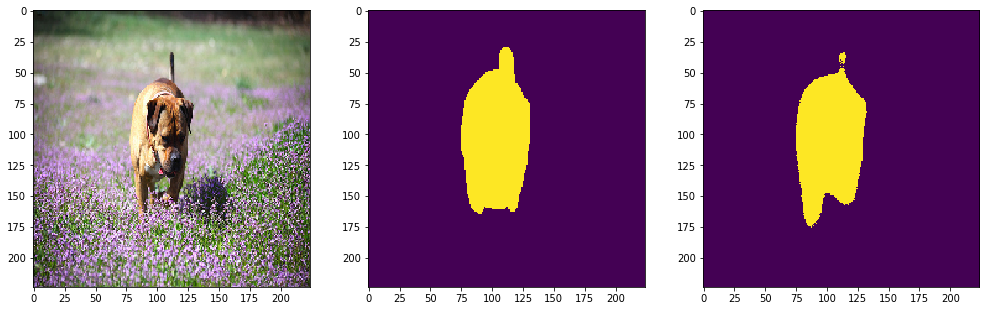

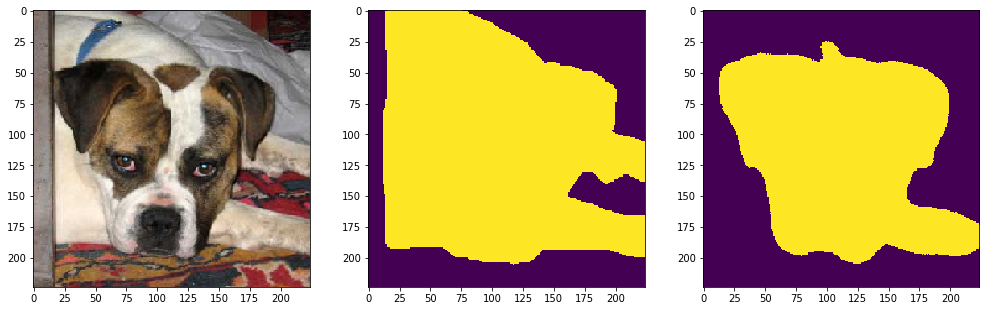

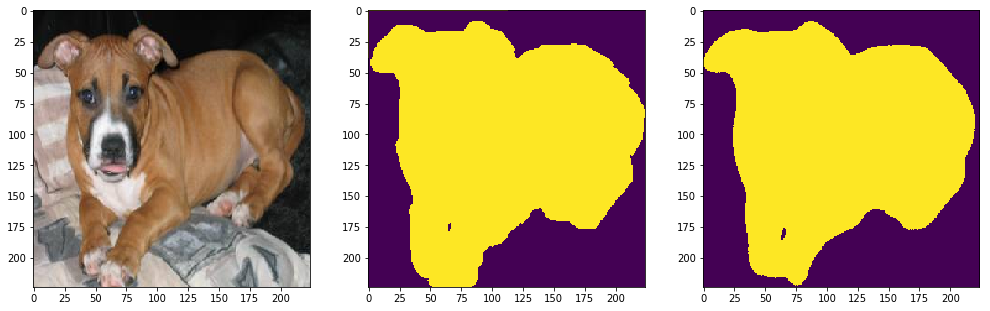

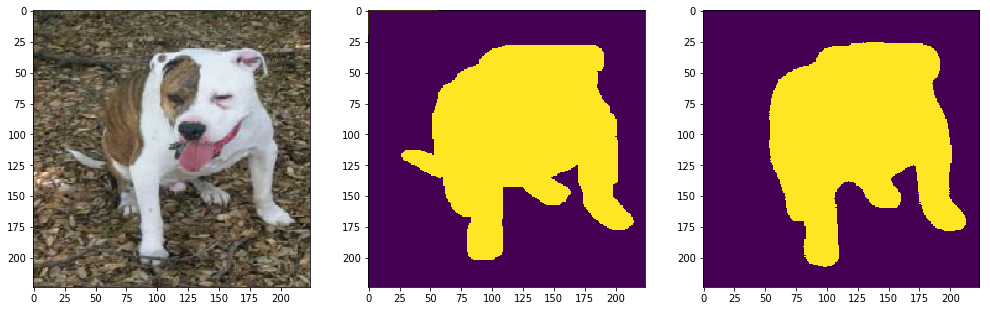

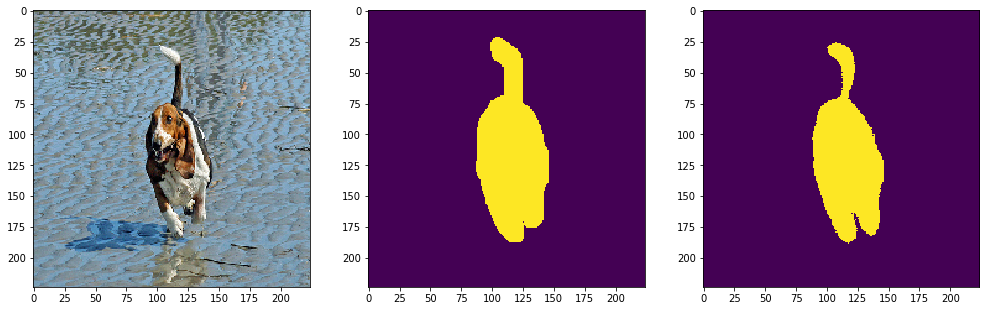

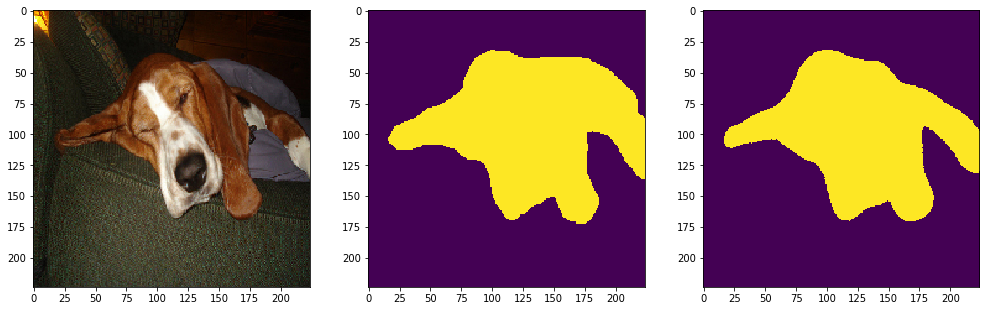

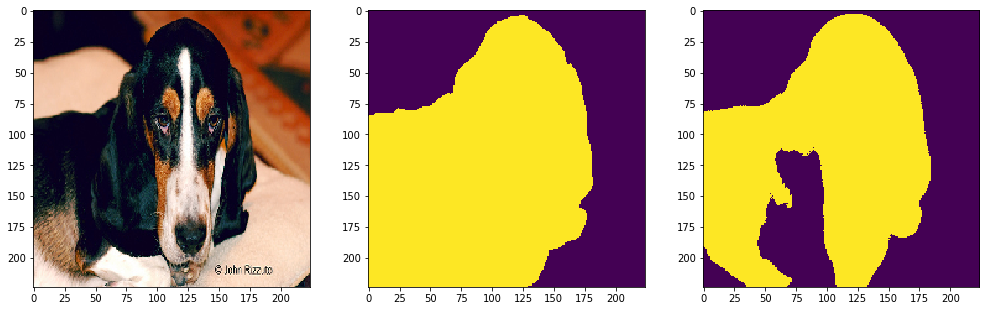

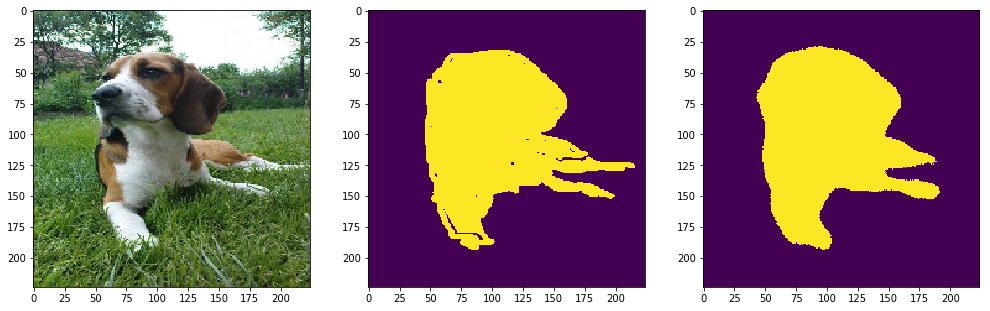

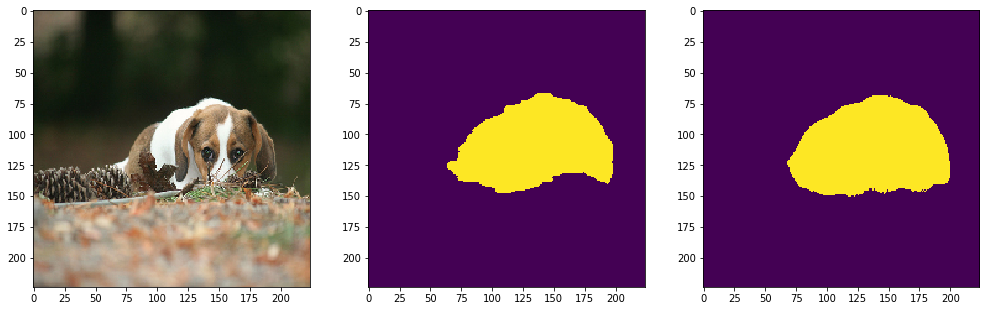

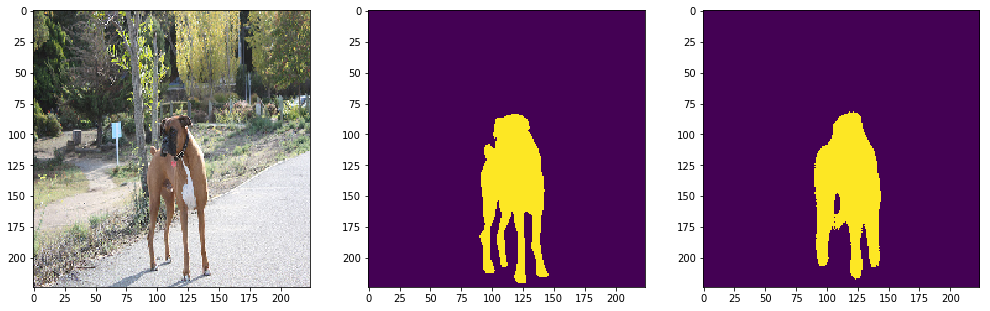

In [29]:
## num_imgs만큼 validation dataset에서 읽어서 정답과 예측값 확인
num_imgs = 10
idx = 0
for image, seg in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(image[0])
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1)
    plt.subplot(num_imgs,3,idx*3+3)
    plt.imshow(pred[idx*batch_size,:,:,1])
    plt.show() 
    idx += 1